# BE 5210: Homework 2

Spring 2026  |  47 points

**Due:** Thursday, 02/05/2026 10:00 PM

**Objective:** Computational modeling of neurons. We gratefully acknowledge Dr. Vijay Balasubramanium (UPenn) for many of the questions in this homework.

In [65]:
# Install Pennsieve

%%capture
!wget -q https://github.com/Pennsieve/pennsieve-agent/releases/download/1.8.12/pennsieve_1.8.12_amd64.deb
!sudo dpkg -i pennsieve_1.8.12_amd64.deb > /dev/null
!sudo apt-get install -f -y > /dev/null
!pip install pennsieve --no-deps
!pip install boto3 s3transfer botocore jmespath grpcio_tools --quiet

In [66]:
# Please uncomment the config code below or upload the config.ini file to /root/.pennsieve
# !pennsieve config wizard

In [67]:
# Set up the notebook environment

%env PENNSIEVE_AGENT_PORT=9002
!pennsieve agent

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import contextmanager
from pennsieve import Pennsieve

class PennsieveStreamer:
    """
    A simplified interface for streaming data from Pennsieve.
    """
    def __init__(self, target_port='localhost:9002'):
        """
        Initialize the connection to the Pennsieve Agent.

        Args:
            target_port (str): The address of the local Pennsieve Agent (default: localhost:9002).
        """
        self.ps = None
        self.dataset = None

        try:
            print(f"Connecting to Pennsieve Agent at {target_port}...")

            @contextmanager
            def suppress_stdout():
                with open(os.devnull, "w") as devnull:
                    old_stdout = sys.stdout
                    sys.stdout = devnull
                    try:
                        yield
                    finally:
                        sys.stdout = old_stdout

            with suppress_stdout():
                self.ps = Pennsieve(target=target_port)

            print("Successfully connected to Pennsieve Agent.")
        except Exception as e:
            print(f"Failed to connect to Pennsieve Agent: {e}")
            print("Ensure the Pennsieve Agent is running (run 'pennsieve agent' in terminal).")
            raise e

    def set_dataset(self, dataset_id: str):
        """
        Set the active dataset by ID or dataset name. Resolves the ID to a name if necessary.

        Args:
            dataset_id (str): The Pennsieve Dataset ID (e.g., 'N:dataset:...').
        """
        print(f"Resolving dataset ID: {dataset_id}")
        datasets_dict = self.ps.get_datasets()

        found_name = None
        if isinstance(datasets_dict, dict):
            for name, id_val in datasets_dict.items():
                if id_val == dataset_id or name == dataset_id:
                    print(f"Found dataset: '{name}'")
                    found_name = name
                    break

        if not found_name:
             raise ValueError(f"Dataset with ID {dataset_id} not found in available datasets.")

        target = found_name

        try:
            self.ps.use_dataset(target)
            self.dataset = self.ps.dataset
            print(f"Active dataset set to: {target}")

        except Exception as e:
            print(f"Error setting dataset: {e}")
            raise e

    def map_package_id(self, package_name: str) -> str:
        """
        Map a package name to its ID.

        Args:
            package_name (str): The name of the package.

        Returns:
            str: The ID of the package.
        """
        packages = self.ps.get(f"https://api.pennsieve.io/datasets/{self.ps.dataset}/packages?filename={package_name}.edf",params={"accept": "*/*"})['packages']
        packages = [p['content'] for p in packages if p['content']['state'] == 'READY' ]
        if len(packages) > 1:
            raise ValueError("Multiple packages with the same name identified. Please use package ID instead.")
        package_id = packages[0]['nodeId']
        return package_id

    def set_package(self, package_id: str):
        """
        Set the active dataset by ID or dataset name. Resolves the ID to a name if necessary.

        Args:
            package_id (str): The Pennsieve Package ID (e.g., 'N:package:...').
        """
        if not self.dataset:
            raise ValueError("Dataset not set. Call set_dataset() first.")

        # map package name to ids
        if not package_id.startswith('N:package'):
            package_id = self.map_package_id(package_id)
        self.package_id = package_id
        print(f"Active package set to: {package_id}")

    def get_clip(self, start_sec: float, end_sec: float, channel_list: list = None, relative_time = True) -> pd.DataFrame:
        """
        Stream a data clip for all channels in a package.

        Args:
            package_id (str): The ID of the TimeSeries package (file).
            start_sec (float): Start time in seconds relative to recording start.
            end_sec (float): End time in seconds relative to recording start.

        Returns:
            pd.DataFrame: A DataFrame containing the streamed data.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        # Get channels to get IDs
        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True)

        if not channels:
            print("No channels found in this package.")
            return pd.DataFrame()

        if channel_list is None:
            channel_ids = [c.id for c in channels]
            channel_names = [c.name for c in channels]
        else:
            channel_ids = [c.id for c in channels if c.name in channel_list]
            channel_names = [c.name for c in channels if c.name in channel_list]

            if not channel_ids:
                print("No matching channels found in this package.")
                return pd.DataFrame()

        data = self.ps.timeseries.getRangeForChannels(
            self.dataset,
            self.package_id,
            channel_ids,
            start_sec,
            end_sec,
            False, # force_refresh
            True   # is_relative_time
        )
        data.columns = channel_names
        data = data.sort_index()
        if relative_time:
            ts = self.get_ts_details_from_name(channel_names[0])
            data.index = data.index - ts['start_time']
        return data

    def get_metadata(self) -> dict:
        """
        Retrieve metadata for the package (channels, rates, units).

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            dict: Metadata including channel count and details (rate, unit, range).
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True

        metadata = {
            "channel_count": len(channels),
            "channels": []
        }

        for c in channels:
            channel_info = {
                "name": getattr(c, 'name', 'Unknown'),
                "id": getattr(c, 'id', 'Unknown'),
                "rate_hz": getattr(c, 'rate', None),
                "unit": getattr(c, 'unit', None),
                "start_time": getattr(c, 'start_time', None),
                "end_time": getattr(c, 'end_time', None)
            }
            metadata["channels"].append(channel_info)

        return metadata

    def get_channel_labels(self) -> list:
        """
        Get a list of channel labels for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of channel labels.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        return [c.name for c in channels]

    def get_channel_indices(self, channel_list: list) -> list:
        """
        Get a list of channel labels for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of channel labels.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        channel_indices = []
        for e, c in enumerate(channels):
            if c.name in channel_list:
                channel_indices.append(e)
        return channel_indices

    def get_ts_details_from_name(self, channel_name: str) -> dict:
        """
        Get details about a specific channel in a TimeSeries package.

        Args:
            package_id (str): The ID of the TimeSeries package.
            channel_name (str): The name of the channel to retrieve details for.

        Returns:
            dict: Details about the specified channel, including rate, unit,
                  start time, and end time.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        if not channels:
            print("No channels found in this package.")
            return {}
        if channel_name not in [c.name for c in channels]:
            print(f"Channel '{channel_name}' not found in this package.")
            return {}
        indice = self.get_channel_indices([channel_name])[0]
        c = channels[indice]
        channel_info = {
              "name": getattr(c, 'name', 'Unknown'),
              "id": getattr(c, 'id', 'Unknown'),
              "rate_hz": getattr(c, 'rate', None),
              "unit": getattr(c, 'unit', None),
              "start_time": getattr(c, 'start_time', None),
              "end_time": getattr(c, 'end_time', None),
        }
        channel_info['duration'] = channel_info['end_time'] - channel_info['start_time']

        return channel_info

    def get_ts_details_from_indice(self, channel_indice: str) -> dict:
        """
        Get details about a specific channel in a TimeSeries package.

        Args:
            package_id (str): The ID of the TimeSeries package.
            channel_name (str): The name of the channel to retrieve details for.

        Returns:
            dict: Details about the specified channel, including rate, unit,
                  start time, and end time.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        c = channels[channel_indice]
        channel_info = {
              "name": getattr(c, 'name', 'Unknown'),
              "id": getattr(c, 'id', 'Unknown'),
              "rate_hz": getattr(c, 'rate', None),
              "unit": getattr(c, 'unit', None),
              "start_time": getattr(c, 'start_time', None),
              "end_time": getattr(c, 'end_time', None),
        }
        channel_info['duration'] = channel_info['end_time'] - channel_info['start_time']

        return channel_info

    def get_annotations(self):
        """
        Get annotations for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of annotations.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        annots = self.ps.get(f"https://api.pennsieve.io/packages/{self.package_id}/annotations",params={"accept": "*/*"})['annotations']

        return annots

env: PENNSIEVE_AGENT_PORT=9002
Pennsieve Agent is already running on port: 9002


## 1. Basic Membrane and Equilibrium Potentials (9 pts)

Before undertaking this section, you may find it useful to read pg. 153-161 of Dayan & Abbott's *Theoretical Neuroscience* (the relevant section of which, Ch. 5, is posted with this homework).

###1
Recall that the potential difference $V_T$ when a mole of ions crosses a cell membrane is defined by the universal gas constant *R* = 8.31 J/mol ̇K, the temperature *T* (in Kelvin), and Faraday's constant *F* = 96,480 C/mol.

$$V_T = \frac{RT}{F}$$

Calculate $V_T$ at human physiological temperature (37&deg;C). (1 pt)



In [68]:
# Your code here
R = 8.31
T = 37 + 273.15
F = 96480
V_T = R * T / F
print(f"{V_T} V")

0.026713790422885575 V


```0.0267 V```

### 2
Use this value $V_T$ to calculate the Nerst equilibrium potentials (in mV) for the $K^+$, $Na^+$, and $Cl^-$ ions, given the following cytoplasm and extracellular concentrations in the squid giant axon\:

*   $K^+$: (120, 4.5)
*   $Na^+$: (15, 145)
*   $Cl^-$: (12, 120)

The first number is the cytoplasmic concentration and the second number is the extracelluar concentration (in mM). (2pt)

In [69]:
# Your code here
# Nernst Equation: E_ion = RT/zF ln (outside / inside) = V_T / z ln (out/in)
def nernst(z:int, outconc: float, inconc: float):
  return V_T / z * np.log(outconc / inconc)

print(f"K+\t{nernst(1, 4.5, 120):.4f}")
print(f"Na+\t{nernst(1, 145, 15):.4f}")
print(f"Cl-\t{nernst(-1, 120, 12):.4f}")

K+	-0.0877
Na+	0.0606
Cl-	-0.0615


```
K+	-0.0877 V
Na+  0.0606 V
Cl-	-0.0615 V
```

###3

#### 3a
Use the Goldman equation,

$$ V_m = V_Tln(\frac{P_K \cdot [K^+]_{out} + P_{Na} \cdot [{Na}^+]_{out} + P_{Cl} \cdot [{Cl}^-]_{in}}{P_K \cdot [K^+]_{in} + P_{Na} \cdot [{Na}^+]_{in} + P_{Cl} \cdot [{Cl}^-]_{out}})$$

to calculate the resting membrane potential, $V_m$, assuming that the ratio of membrane permeabilities

$$P_K : P_{Na} : P_{Cl} = 1.0 : 0.045 : 0.45$$

Use the ion concentrations given in question 1.2. (2 pts)

In [70]:
# Your code here
P_K = 1.0
P_Na = 0.045
P_Cl = 0.45

V_M = V_T * np.log(
    (P_K * 4.5 + P_Na * 145 + P_Cl * 12) /
    (P_K * 120 + P_Na * 15 + P_Cl * 120)
)
print(f"{V_M:.4f} V")

-0.0632 V


```V_M = -0.0632 V```

####3b
Calculate the membrane potential at the peak action potential, assuming a permeability ratio of 1.0 : 11 : 0.45, again using the ion concentrations given above in Question 1.2 (2 pts).

In [71]:
# Your code here
P_K = 1.0
P_Na = 11
P_Cl = 0.45

V_M = V_T * np.log(
    (P_K * 4.5 + P_Na * 145 + P_Cl * 12) /
    (P_K * 120 + P_Na * 15 + P_Cl * 120)
)
print(f"{V_M:.4f} V")

0.0415 V


```V_M = 0.0415 V```

###4
The amplitudes of the multi-unit signals in HW0 and local field potentials (LFPs) in HW1 had magnitudes on the order of 10 to 100 microvolts. The voltage at the peak of the action potential (determined using the Goldman equation above) has a magnitude on the order of 10 millivolts. Briefly explain why we see this difference in magnitude.

Hint 1: Voltage is the difference in electric potential between two points. What are the two points for our voltage measurement in the multi-unit and LFP signals? What are the two points for our voltage measurements of the action potential?

Hint 2: The resistance of the neuronal membrane is typically much higher than the resistance of the extracellular fluid. (2 pts)

In [72]:
# Your code here

```
The two factors are:

the voltage is being measured indirectly in LFPs. The voltage measurement in multi-unit and LFP signals is between two points on the scalp. Since the voltage drop is across the membrane, the measurement from the scalp (or just another region of the brain) is going to be measured from further away (indirectly) and have a smaller signal.

the voltage drop is smaller if the resistance is lower. Since V = IR, the resistance of the membrane being larger means the voltage is larger. The resistance of the extracellular fluid being smaller means the voltage drop is smaller.
```

## 2. Integrate and Fire Model (38 pts)

You may find it useful to read pg. 162-166 of Dayan and Abbott for this section. The general differential equation for the integrate and fire model is

$$\tau_m\frac{dV}{dt} = V_m - V(t) + R_m I_e(t)$$

where $\tau_m = 10\, \rm ms$ is the membrane time constant, describing how fast the current is leaking through the membrane, $V_m$ in this case is constant and represents the resting membrane potential (which you have already calculated in question 1.3.a), and $V(t)$ is the actual membrane potential as a function of time. $R_m = 10^7\, \Omega$ is the constant total membrane resistance, and $I_e(t)$ is the fluctuating incoming current. Here, we do not explicitly model the action potentials (that's Hodgkin-Huxley) but instead model the neuron's behavior leading up to and after the action potential.

Use a $\Delta t = 10\, \rm \mu s$ ($\Delta t$ is the discrete analog of the continuous $dt$). Remember, one strategy for modeling differential equations like this is to start with an initial condition (here, $V(0)=V_m$), then calculate the function change (here, $\Delta V$, the discrete analog to $dV$) and then add it to the function (here, $V(t)$) to get the next value at $t+\Delta t$. Once/if the membrane potential reaches a certain threshold ($V_{th} = -50\, \rm mV$), you will say that an action potential has occurred and reset the potential back to its resting value.

###1
Model the membrane potential with a constant current injection (i.e., $I_e(t) = I_e = 2 {\rm nA}$). Plot your membrane potential as a function of time to show at least a handful of "firings." (8 pts)

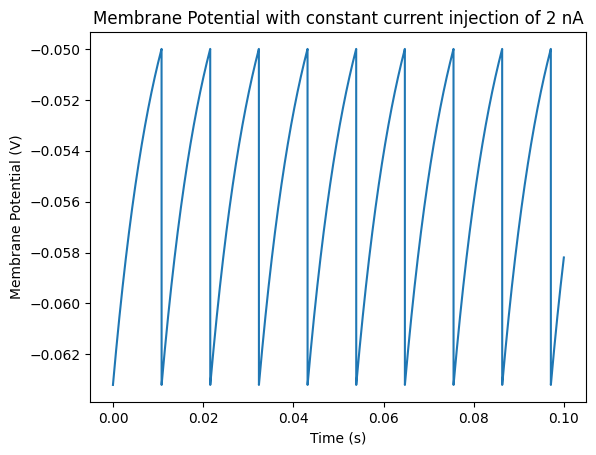

In [73]:
import numpy as np
import matplotlib.pyplot as plt
# Your code here
tau_m = 10e-3 # milliseconds
delta_t = 1e-5 # microseconds
V_m = -0.0632 # from above
R_m = 1e7 # Ohms
V_th = -0.050 # V
I_e = 2e-9 # A

time = np.arange(0, 0.1, delta_t)
V = np.zeros_like(time)
spikes = []

V[0] = V_m
for i in range(1, len(time)):
  dV = delta_t * (V_m - V[i-1] + R_m * I_e) / tau_m

  V[i] = V[i-1] + dV

  if V[i] > V_th:
    V[i] = V_m
    # print(f"Firing at time {time[i]} s")
    spikes.append(time[i])

plt.plot(time, V)
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.title("Membrane Potential with constant current injection of 2 nA")
plt.show()

###2
Produce a plot of firing rate (in Hz) versus injection current, over the range of 1-4 nA. (4 pts)

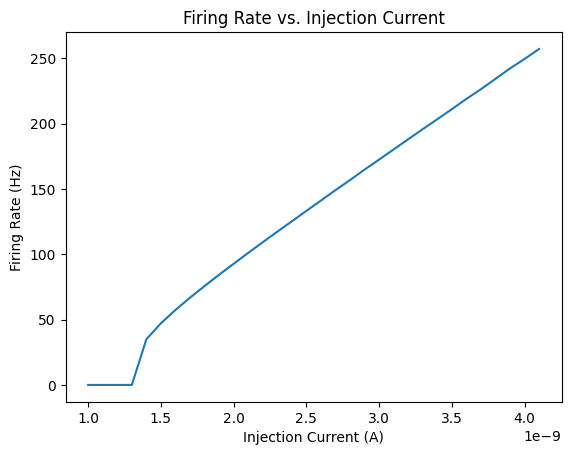

In [80]:
# Your code here
injection_currents = np.arange(1e-9, 4e-9 + 1e-10, 1e-10)
firing_rates = np.zeros_like(injection_currents)

for idx, I_e in enumerate(injection_currents):
  time = np.arange(0, 0.1, delta_t)
  V = np.zeros_like(time)

  V[0] = V_m
  for i in range(1, len(time)):
    dV = delta_t * (V_m - V[i-1] + R_m * I_e) / tau_m

    V[i] = V[i-1] + dV

    if V[i] > V_th:
      V[i] = V_m
      firing_rates[idx] = 1 / time[i]
      break

  else:
    firing_rates[idx] = 0

plt.plot(injection_currents, firing_rates)
plt.xlabel("Injection Current (A)")
plt.ylabel("Firing Rate (Hz)")
plt.title("Firing Rate vs. Injection Current")
plt.show()

###3
``I521_A0002_D001`` contains a dynamic current injection in nA. Plot the membrane potential of your neuron in response to this variable injection current. Use [``plt.subplots()``](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) to place the plot of the membrane potential above the injection current so that they both have the same time axis. (Hint: the sampling frequency of the current injection data is different from the sampling frequency ($\frac{1}{\Delta t}$) that we used above.) (4 pts)


In [75]:
# Your code here
streamer = PennsieveStreamer()
streamer.set_dataset("N:dataset:cf2376f0-aede-4c3c-b6a7-0cefded0d64c")
streamer.set_package("N:package:1853bb34-f15e-4dbd-a6dd-cf3e9a3bbef9")

Connecting to Pennsieve Agent at localhost:9002...
Successfully connected to Pennsieve Agent.
Resolving dataset ID: N:dataset:cf2376f0-aede-4c3c-b6a7-0cefded0d64c
Found dataset: 'Homework Data'
Active dataset set to: Homework Data
Active package set to: N:package:1853bb34-f15e-4dbd-a6dd-cf3e9a3bbef9


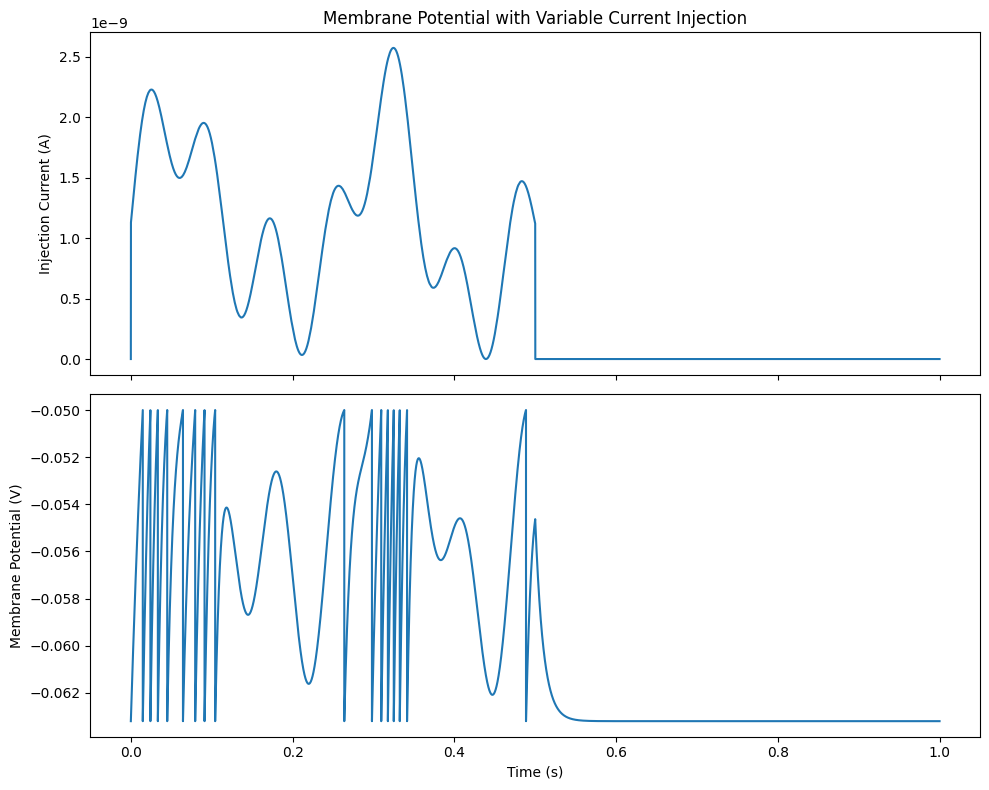

In [76]:
sampling_freq = streamer.get_metadata()['channels'][0]['rate_hz']
CLIP_LENGTH = 1
injection = streamer.get_clip(0, CLIP_LENGTH)

time = np.arange(0, CLIP_LENGTH, delta_t)
V = np.zeros_like(time)
injection_sample = np.zeros_like(time)

spikes = []
V[0] = V_m
for i in range(1, len(time)):
  # sample from injection curve at given time
  I_e = injection.iloc[int(time[i] * sampling_freq)]["Ie"] * 1e-9 * 1e-6
  injection_sample[i] = I_e

  dV = delta_t * (V_m - V[i-1] + R_m * I_e) / tau_m

  V[i] = V[i-1] + dV

  if V[i] > V_th:
    V[i] = V_m
    spikes.append(time[i])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Injection Current
ax1.plot(time, injection_sample)
ax1.set_ylabel("Injection Current (A)")
ax1.set_title("Membrane Potential with Variable Current Injection")

# Plot 2: Membrane Potential
ax2.plot(time, V)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Membrane Potential (V)")

plt.tight_layout()
plt.show()

###4
Real neurons have a refractory period after an action potential that prevents them from firing again right away. We can include this behavior in the model by adding a spike-rate adaptation conductance term, $g_{sra}(t)$ (modeled as a potassium conductance), to the model
$$\tau_m\frac{dV}{dt} = V_m - V(t) - r_m g_{sra}(t)(V(t)-V_K)+ R_m I_e(t)$$
where
 $$ \tau_{sra}\frac{dg_{sra}(t)}{dt} = -g_{sra}(t).$$
Every time an action potential occurs, we increase $g_{sra}$ by a certain constant amount, $g_{sra} = g_{sra} + \Delta g_{sra}$. Use $r_m \Delta g_{sra} = 0.06$. Use a conductance time constant of $\tau_{sra} = 100\, \rm ms$, a potassium equilibrium potential of $V_K = -70\, \rm mV$, and $g_{sra}(0) = 0$. (Hint: How can you use the $r_m \Delta g_{sra}$ value to update voltage and conductance separately in your simulation?)

####4a
Implement this addition to the model (using the same other parameters as in question 2.1) and plot the membrane potential over 200 ms. (8 pts)

/tmp/ipython-input-4010545200.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


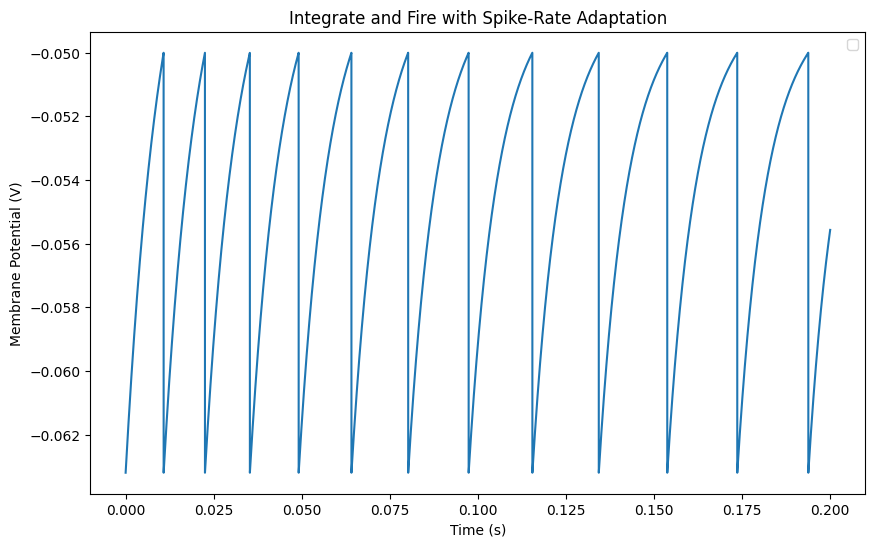

In [82]:
import numpy as np
import matplotlib.pyplot as plt

tau_m = 10e-3
R_m = 1e7
V_m = -0.0632
V_th = -0.050
V_K = -0.070
I_e = 2e-9

tau_sra = 0.1
rm_delta_gsra = 0.06

T = 0.2
delta_t = 1e-5
time = np.arange(0, T, delta_t)
V = np.zeros_like(time)
rm_gsra = np.zeros_like(time)

V[0] = V_m
rm_gsra[0] = 0

for i in range(1, len(time)):

    d_rm_gsra = -(rm_gsra[i-1] / tau_sra) * delta_t
    rm_gsra[i] = rm_gsra[i-1] + d_rm_gsra

    numerator = (V_m - V[i-1]) - (rm_gsra[i-1] * (V[i-1] - V_K)) + (R_m * I_e)
    dV = (delta_t / tau_m) * numerator

    V[i] = V[i-1] + dV

    if V[i] > V_th:
        V[i] = V_m
        rm_gsra[i] += rm_delta_gsra

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(time, V)
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.title("Integrate and Fire with Spike-Rate Adaptation")
plt.legend()

plt.show()

####4b
Plot the inter-spike interval (the time between the spikes) of all the spikes that occur in 500 ms. (2 pts)

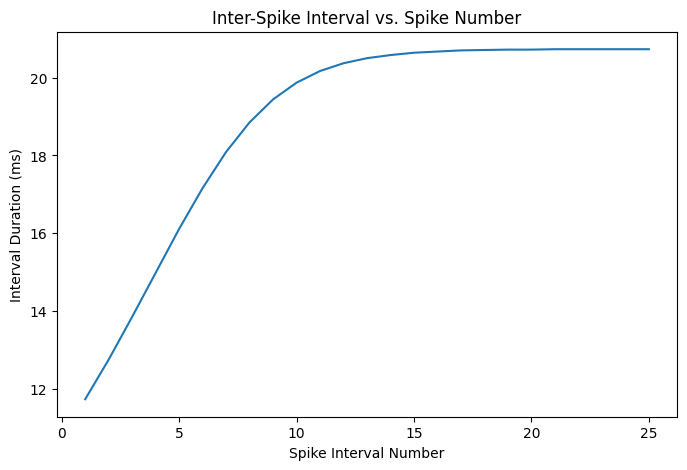

In [78]:
# Your code here
# same thing but 500 ms
T = 0.5

time = np.arange(0, T, delta_t)
V = np.zeros_like(time)
rm_gsra = np.zeros_like(time)

V[0] = V_m
rm_gsra[0] = 0
spike_times = []

for i in range(1, len(time)):

    d_rm_gsra = -(rm_gsra[i-1] / tau_sra) * delta_t
    rm_gsra[i] = rm_gsra[i-1] + d_rm_gsra

    numerator = (V_m - V[i-1]) - (rm_gsra[i-1] * (V[i-1] - V_K)) + (R_m * I_e)
    dV = (delta_t / tau_m) * numerator

    V[i] = V[i-1] + dV

    if V[i] > V_th:
        V[i] = V_m
        rm_gsra[i] += rm_delta_gsra
        spike_times.append(time[i])

intervals = np.diff(spike_times)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(intervals) + 1), intervals * 1000) # * 1000 for ms
plt.title("Inter-Spike Interval vs. Spike Number")
plt.xlabel("Spike Interval Number")
plt.ylabel("Interval Duration (ms)")
plt.show()

####4c
Explain how the spike-rate adaptation term we introduced above might be contributing to the behavior you observe in 2.4.b. (2 pts)

```
The adaptation term adds to the gsra term which subtracts from the membrane potential. After more and more APs happen, the gsra term builds up to be larger and larger in magnitude, which has an increasing effeect on decreasing the membrane potential (hyperpolarization) which makes the next AP harder to occur. Then, this results in more injection current required to actually depolarize, and so the spike interval is longer since more current needs to be injected before we cross threshold.
```

###5
Pursue an extension of this basic integrate and fire model. A few ideas are: implement the Integrate-and-Fire-or-Burst Model of Smith et al. 2000 (included); implement the Hodgkin-Huxley model (see Dayan and Abbot, pg. 173); provide some sort of interesting model of a population of neurons; or perhaps model what an electrode sampling at 200 Hz would record from the signal you produce in question 2.3. Feel free to be creative.
We reserve the right to give extra credit to particularly interesting extensions and will in general be more generous with points for more difficult extensions (like the first two ideas), though it is possible to get full credit for any well-done extension.

####5a
Briefly describe what your extension is and how you will execute it in code. (6 pts)

```
I will implement the Hodgkin-Huxley model. The HH model doesn't just reset the membrane potential after an AP, but instead models it using the closing (gating) of the sodium channel and the opening of the potassium channel. This way, there's a gradual (not that slow but just not instantaneous) repolarization of the membrane.

I will do this by adding three variables for the opening and gating of the ion channels. membrane voltage will be affected now both by the injected current but also the current of the ions flowing through the Na and K channels. Then, the resulting voltage will be used to calculate the probability of the channel being open/closed/gated. Let's let the values of n, m, and h be the probabilities of each membrane gate being open/closed (not all gates opening discretely and instantanouesly)
```

####5b
Provide an interesting figure along with an explanation illustrating the extension. (4 pts)

<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-20311209.py:85: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Input Current ($\mu A/cm^2$)')


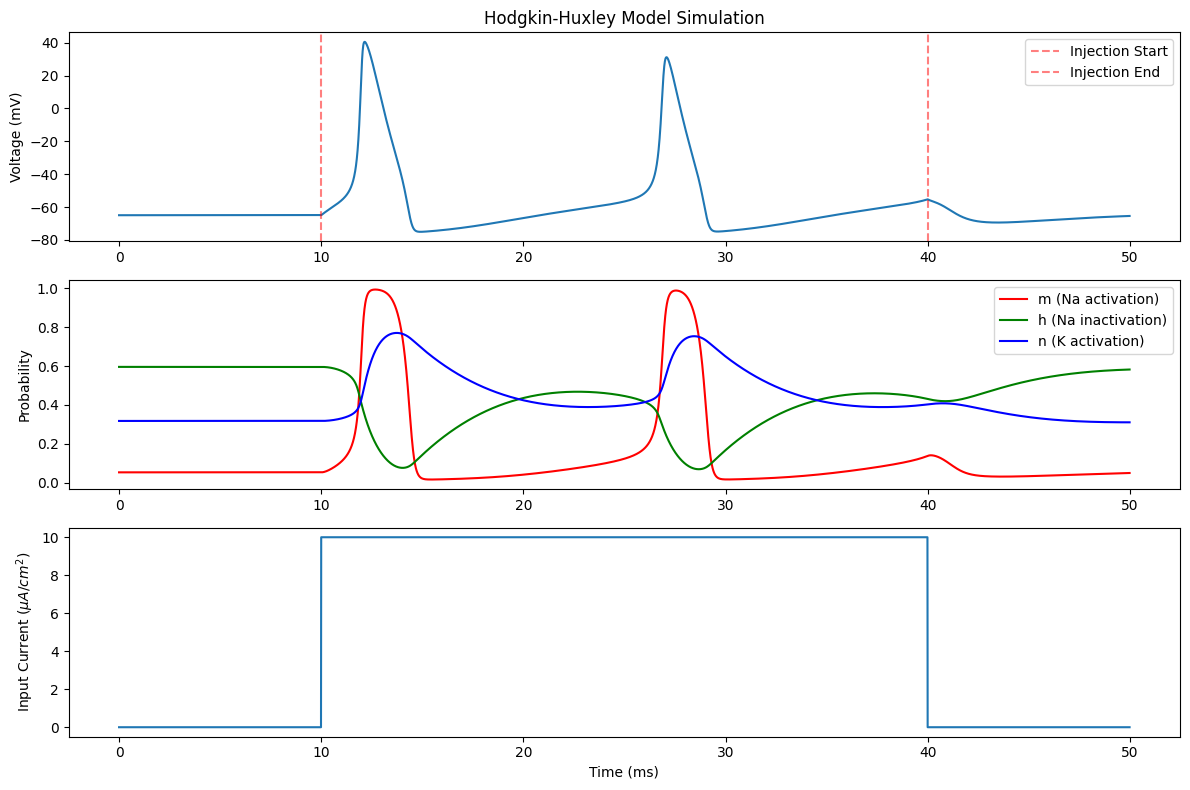

In [79]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt

C_m  = 1.0
g_Na = 120.0
g_K  = 36.0
g_L  = 0.3

E_Na = 50.0
E_K  = -77.0
E_L  = -54.387

# Time
T = 50.0
dt = 0.01
time = np.arange(0, T, dt)

# Input Current -- Pulse
I_inj = np.zeros_like(time)
I_inj[int(10/dt):int(40/dt)] = 10.0

# Rate Functions
def alpha_n(V): return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))
def beta_n(V):  return 0.125 * np.exp(-(V + 65.0) / 80.0)

def alpha_m(V): return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))
def beta_m(V):  return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V): return 0.07 * np.exp(-(V + 65.0) / 20.0)
def beta_h(V):  return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

V = np.zeros_like(time)
n = np.zeros_like(time)
m = np.zeros_like(time)
h = np.zeros_like(time)

V[0] = -65
n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))
m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))

for i in range(1, len(time)):
    V_curr = V[i-1]

    an, bn = alpha_n(V_curr), beta_n(V_curr)
    am, bm = alpha_m(V_curr), beta_m(V_curr)
    ah, bh = alpha_h(V_curr), beta_h(V_curr)

    n[i] = n[i-1] + dt * (an * (1 - n[i-1]) - bn * n[i-1])
    m[i] = m[i-1] + dt * (am * (1 - m[i-1]) - bm * m[i-1])
    h[i] = h[i-1] + dt * (ah * (1 - h[i-1]) - bh * h[i-1])

    I_Na = g_Na * (m[i-1]**3) * h[i-1] * (V_curr - E_Na)
    I_K = g_K * (n[i-1]**4) * (V_curr - E_K)
    I_L = g_L * (V_curr - E_L)

    dV = (I_inj[i-1] - I_Na - I_K - I_L) / C_m * dt
    V[i] = V_curr + dV

# Plotting
plt.figure(figsize=(12, 8))

# Plot Voltage
plt.subplot(3, 1, 1)
plt.plot(time, V)
plt.ylabel('Voltage (mV)')
plt.title('Hodgkin-Huxley Model Simulation')
plt.axvline(10, color='r', linestyle='--', alpha=0.5, label='Injection Start')
plt.axvline(40, color='r', linestyle='--', alpha=0.5, label='Injection End')
plt.legend(loc='upper right')

# Plot Gating Variables
plt.subplot(3, 1, 2)
plt.plot(time, m, 'r', label='m (Na activation)')
plt.plot(time, h, 'g', label='h (Na inactivation)')
plt.plot(time, n, 'b', label='n (K activation)')
plt.ylabel('Probability')
plt.legend()

# Plot Injection Current
plt.subplot(3, 1, 3)
plt.plot(time, I_inj)
plt.xlabel('Time (ms)')
plt.ylabel('Input Current ($\mu A/cm^2$)')

plt.tight_layout()
plt.show()

```
The graphs show three stacked plots. The bottom one is the input current (injected). The top one is the membrane potential. You can see the characteristic gradual depolarization, the sharp increase as the sodium channels open, and the sharp decrease as the potassium channels open.

These voltage changes are accompanied with plots of the channel activation probabilities, which describe the cellular mechanisms behind why we see the voltage's characteristic shape.
```